Load Necessary Libraries

In [14]:
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler


Step 1: Import Data set and select relevant variables to work with

In [ ]:

file_path = r"c:\Users\LENOVO\Desktop\DSA Masters\Data Science Lifecycle\Final Exams\Financial Inclusion\DatabankWide.xlsx"
data = pd.read_excel(file_path)
# Select relevant columns for financial access and inclusion analysis
selected_columns = [
    'Country name', 'Country code', 'Year','Adult populaiton','Income group',
    
    'Account (% age 15+)', # Owns a bank account or mobile money account
    
    'Owns a debit or credit card (% age 15+)',
    'Used a debit or credit card (% age 15+)',
    'Made a deposit (% with a financial institution account, age 15+)',
    'Has an inactive account (% age 15+)',
  
    'Use a mobile money account two or more times a month (% age 15+)',
    'Saved any money (% age 15+)',
    
    'Saved at a financial institution or using a mobile money account (% age 15+)',
    'Borrowed any money from a formal financial institution or using a mobile money account (% age 15+)',
      
    'Made or received a digital payment (% age 15+)',
    
    'Own a mobile phone (% age 15+)',
    'Has access to the internet (% age 15+)',
    
    'Account, rural (% age 15+)',
    'Account, urban (% age 15+)',
    
    'Account, out of labor force (% age 15+)',
    'Account, in labor force (% age 15+)',
    
    'Owns a debit or credit card, female (% age 15+)',	
    'Owns a debit or credit card, male (% age 15+)',	
        
    'Saved any money, female (% age 15+)',	
    'Saved any money, male (% age 15+)',
    
    'Saved for education or school fees, female (% age 15+)',	
    'Saved for education or school fees, male (% age 15+)',	
    
    'Saved for old age, female (% age 15+)',	
    'Saved for old age, male (% age 15+)',	
    
    'Saved to start, operate, or expand a farm or business, female (% age 15+)',	
    'Saved to start, operate, or expand a farm or business, male (% age 15+)',
    
    'Saved using a savings club or a person outside the family, female (% age 15+)',	
    'Saved using a savings club or a person outside the family, male (% age 15+)',
    
    'Borrowed any money, female (% age 15+)',	
    'Borrowed any money, male (% age 15+)',
    
    'Borrowed from a formal financial institution, female (% age 15+)',	
    'Borrowed from a formal financial institution, male (% age 15+)',
    
    'Borrowed from a savings club, female (% age 15+)',
    'Borrowed from a savings club, male (% age 15+)',
    
    'Borrowed from a store by buying on credit, female (% age 15+)',	
    'Borrowed from a store by buying on credit, male (% age 15+)',
    
    'Borrowed from family or friends, female (% age 15+)',	
    'Borrowed from family or friends, male (% age 15+)',

    'Borrowed for education or school fees, female (% age 15+)',	
    'Borrowed for education or school fees, male (% age 15+)',
    
    'Borrowed for health or medical purposes, female (% age 15+)',	
    'Borrowed for health or medical purposes, male (% age 15+)',
    
    'Borrowed to start, operate, or expand a farm or business, female (% age 15+)',	
    'Borrowed to start, operate, or expand a farm or business, male (% age 15+)',
    
    'Has an outstanding housing loan, female (% age 15+)',	
    'Has an outstanding housing loan, male (% age 15+)'
   
]

# Filter the dataset with selected columns
data = data[selected_columns]

east_african_countries = ["Burundi","Kenya","Rwanda","Tanzania","Uganda"]

# Assume the dataframe is named 'data' and the column containing country names is 'Country'
data = data[data['Country name'].isin(east_african_countries)]

print(data.columns)



Step 2: Data preprocessing

In [ ]:
# Function to impute missing values
def impute_missing_values(data):
    for col in data.columns:
        if data[col].dtype in ['int64', 'float64']:  # Numeric variables
            if data[col].skew() > 1 or data[col].skew() < -1:  # If highly skewed, use median
                data[col].fillna(data[col].median(), inplace=True)
            else:  # Otherwise, use mean
                data[col].fillna(data[col].mean(), inplace=True)
        else:  # Categorical variables
            data[col].fillna(data[col].mode()[0], inplace=True)
    return data

data = impute_missing_values(data)

In [ ]:
# Encode Categorical Variables
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_categorical_variables(data, one_hot_threshold=10):
    encoded_data = data.copy()  # Copy data to avoid modifying original dataset
    label_encoders = {}  # Store label encoders for decoding later
    
    # Iterate through categorical columns, excluding 'Country name'
    for col in encoded_data.select_dtypes(include=['object', 'category']).columns:
        if col == 'Country name':
            continue  # Skip encoding for 'Country name'
        
        unique_values = encoded_data[col].nunique()
        
        if unique_values <= one_hot_threshold:
            # Apply Label Encoding
            le = LabelEncoder()
            encoded_data[col] = le.fit_transform(encoded_data[col])
            label_encoders[col] = le  # Store encoder
        else:
            # Apply One-Hot Encoding
            encoded_df = pd.get_dummies(encoded_data[col], prefix=col, drop_first=True)
            encoded_data = pd.concat([encoded_data.drop(columns=[col]), encoded_df], axis=1)
    
    return encoded_data, label_encoders  # Return encoded data and encoders for decoding

# Unpack the returned values into separate variables
encoded_data, label_encoders = encode_categorical_variables(data)


data = encoded_data



In [ ]:
# Feature engineering
data['Has an active Account (% age 15+)'] = data['Account (% age 15+)'] - data['Has an inactive account (% age 15+)']

In [ ]:

# Ensure active accounts do not exceed 100% or go below 0%
data['Has an active Account (% age 15+)'] = data['Has an active Account (% age 15+)'].clip(0, 100)

# Define weights for each dimension
weights = {
    'ownership': 0.4,  # Weight for ownership
    'access': 0.3,  # Weight for access
    'usage': 0.3,  # Weight for usage
}

# Calculate dimension scores
# Ownership Score
data['ownership_score'] = (
    data['Account (% age 15+)'] * 0.5 +  # Weight for account ownership
    data['Owns a debit or credit card (% age 15+)'] * 0.3 +  # Weight for card ownership
    data['Has an active Account (% age 15+)'] * 0.2  # Weight for active accounts
) * weights['ownership']

# Access Score
# Since we don't have direct access variables, we can use ownership variables as proxies
data['access_score'] = (
    data['Account (% age 15+)'] * 0.6 +  # Proxy for access via account ownership
    data['Owns a debit or credit card (% age 15+)'] * 0.4  # Proxy for access via card ownership
) * weights['access']

# Usage Score
data['usage_score'] = (
    data['Used a debit or credit card (% age 15+)'] * 0.4 +  # Weight for card usage
    data['Made a deposit (% with a financial institution account, age 15+)'] * 0.4 +  # Weight for deposits
    data['Has an active Account (% age 15+)'] * 0.2  # Weight for active accounts
) * weights['usage']

# Calculate the Financial Inclusion Index (FII)
data['financial_inclusion_index'] = (
    data['ownership_score'] +
    data['access_score'] +
    data['usage_score']
) * 100  # Scale to 0-100

# Display the results
print(data[['Account (% age 15+)', 'Owns a debit or credit card (% age 15+)', 'Used a debit or credit card (% age 15+)',
            'Made a deposit (% with a financial institution account, age 15+)', 'Has an inactive account (% age 15+)',
            'financial_inclusion_index']])

In [ ]:
# Exclude columns used to calculate financial inclusion index
exclude_columns = [
    'Account (% age 15+)', 
    'Owns a debit or credit card (% age 15+)',
    'Used a debit or credit card (% age 15+)',
    'Made a deposit (% with a financial institution account, age 15+)',
    'Has an inactive account (% age 15+)',
    'ownership_score',
    'access_score',
    'usage_score'
]

# Drop the specified columns from the DataFrame
data = data.drop(columns=exclude_columns, errors='ignore')

# Display the updated DataFrame
print(data.head())


Step 3: Exploratory Data Analysis

In [ ]:
# Identify variables that affect financial_inclusion_index

correlation_matrix = data.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['financial_inclusion_index']].sort_values(by='financial_inclusion_index', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with financial_inclusion_index')
plt.show()


In [ ]:
Corr_table = correlation_matrix[['financial_inclusion_index']].sort_values(by='financial_inclusion_index', ascending=False)

# Filter variables with correlation > 0.6
selected_variables = Corr_table[Corr_table['financial_inclusion_index'] >= 0.7]

# Extract the variable names (index of the DataFrame)
selected_variable_names = selected_variables.index.tolist()

# Subset the original data using the selected variable names
ML_data = data[selected_variable_names]



Financial Service-Usage/Access Distribution Across Population Demographics

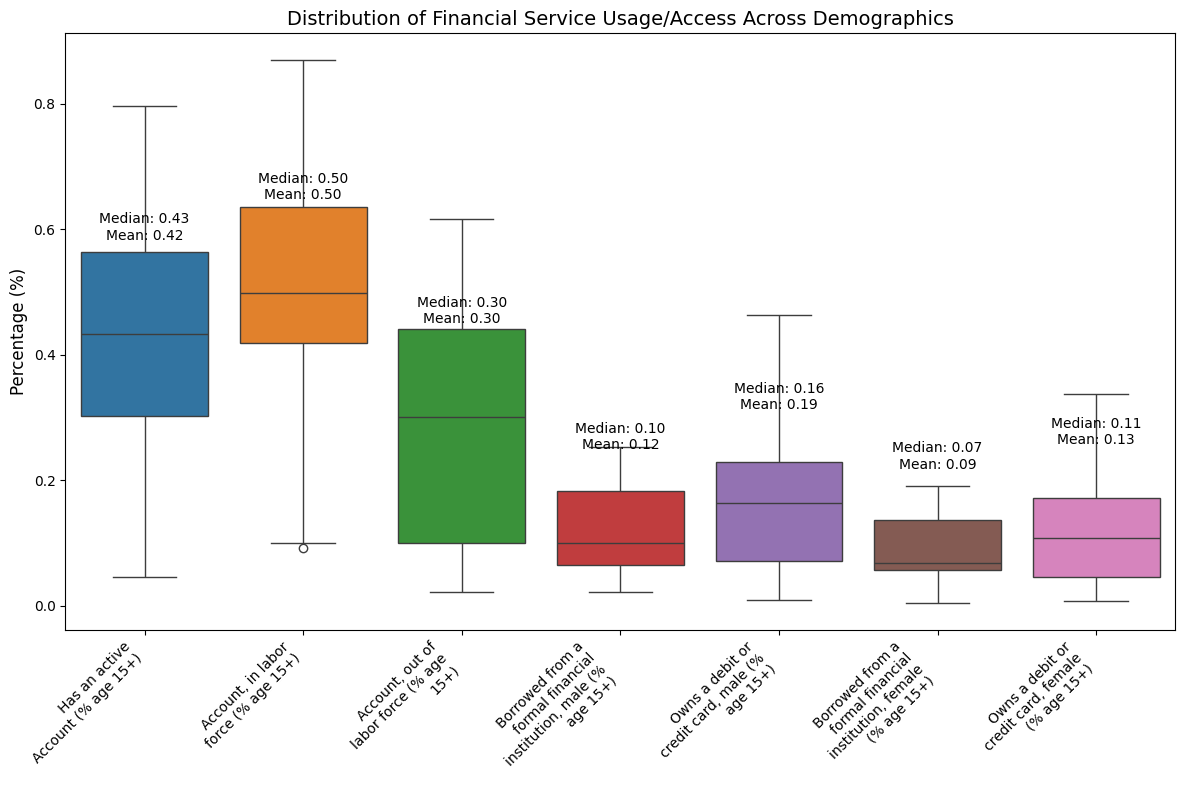

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
from matplotlib.patches import FancyBboxPatch

# Load your dataset (assuming it's already loaded as `data`)
# Example: data = pd.read_csv('financial_inclusion_data.csv')

# Analyze distribution across demographics (e.g., gender, age, labor force status)
demographic_columns = [
    'Has an active Account (% age 15+)',
    'Account, in labor force (% age 15+)',
    'Account, out of labor force (% age 15+)',
    'Borrowed from a formal financial institution, male (% age 15+)',
    'Owns a debit or credit card, male (% age 15+)',
    'Borrowed from a formal financial institution, female (% age 15+)',
    'Owns a debit or credit card, female (% age 15+)'
]

# Create a DataFrame for plotting
demographic_data = data[demographic_columns]

# Create a box plot
plt.figure(figsize=(12, 8))
box_plot = sns.boxplot(data=demographic_data)

# Add statistics annotations (Median, Mean) inside the box plot area with a white background box
for i, column in enumerate(demographic_columns):
    # Get the statistics
    median = demographic_data[column].median()
    mean = demographic_data[column].mean()

    # Create the label text
    label_text = f'Median: {median:.2f}\nMean: {mean:.2f}'

    # Calculate positions for the annotation box
    y_position = median  # Use median position for label placement
    offset = 0.1  # Small offset to avoid exact overlap with the median line

    # Create a FancyBboxPatch for the box around the label
    
    # Place the label inside the box
    plt.text(i, y_position + offset + 0.05, label_text, ha='center', color='black', fontsize=10, zorder=15)

# Wrap labels on the x-axis
wrapped_labels = [textwrap.fill(label, 20) for label in demographic_columns]  # Wrap to 20 characters per line
plt.xticks(ticks=range(len(demographic_columns)), labels=wrapped_labels, rotation=45, ha='right')

# Add title and labels
plt.title('Distribution of Financial Service Usage/Access Across Demographics', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()





Financial Service-Usage/Access Distribution Across Socio-Economic Dynamics

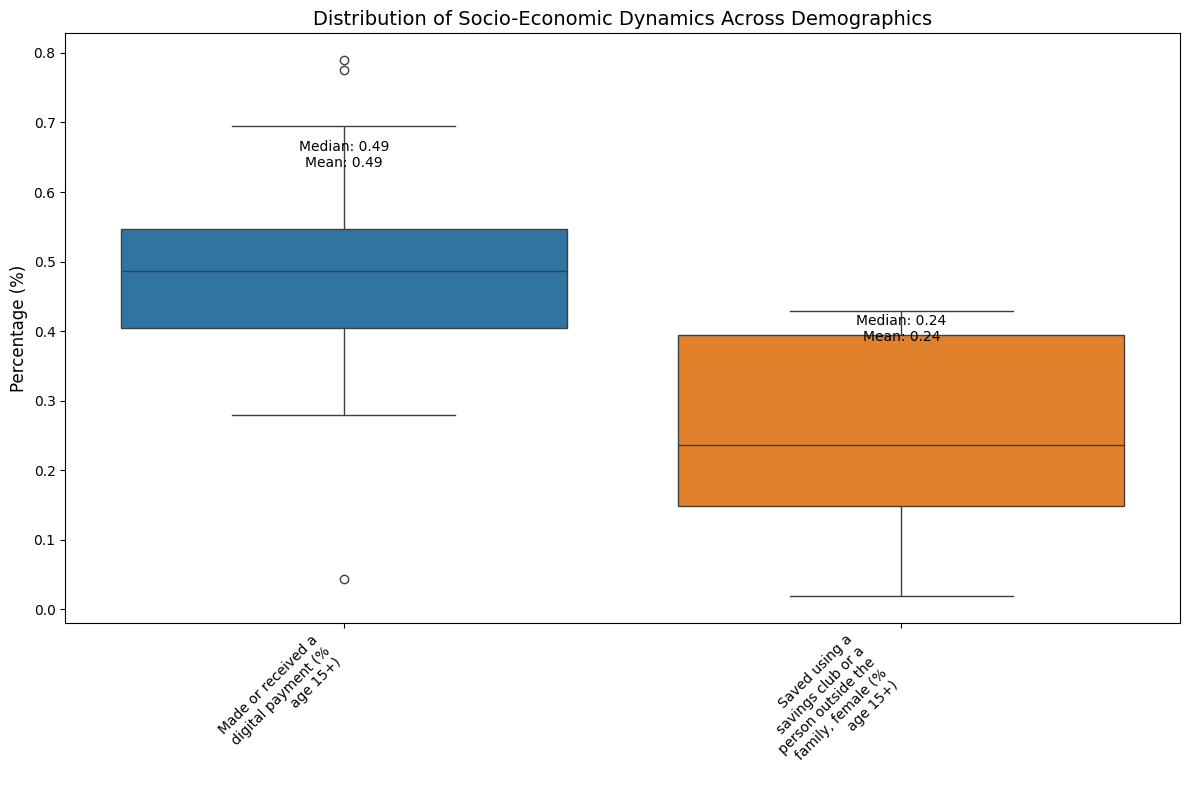

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
from matplotlib.patches import FancyBboxPatch

# Load your dataset (assuming it's already loaded as `data`)
# Example: data = pd.read_csv('financial_inclusion_data.csv')

# Analyze distribution across socio-economic dynamics (e.g., digital payments, savings)
socio_economic_columns = [
    'Made or received a digital payment (% age 15+)',
    'Saved using a savings club or a person outside the family, female (% age 15+)'
]

# Create a DataFrame for plotting
socio_economic_data = data[socio_economic_columns]

# Create a box plot
plt.figure(figsize=(12, 8))
box_plot = sns.boxplot(data=socio_economic_data)

# Add statistics annotations (Median, Mean) inside the box plot area with a white background box
for i, column in enumerate(socio_economic_columns):
    # Get the statistics
    median = socio_economic_data[column].median()
    mean = socio_economic_data[column].mean()

    # Create the label text
    label_text = f'Median: {median:.2f}\nMean: {mean:.2f}'

    # Calculate positions for the annotation box
    y_position = median  # Use median position for label placement
    offset = 0.1  # Small offset to avoid exact overlap with the median line

    # Create a FancyBboxPatch for the box around the label
    
    # Place the label inside the box
    plt.text(i, y_position + offset + 0.05, label_text, ha='center', color='black', fontsize=10, zorder=15)

# Wrap labels on the x-axis
wrapped_labels = [textwrap.fill(label, 20) for label in socio_economic_columns]  # Wrap to 20 characters per line
plt.xticks(ticks=range(len(socio_economic_columns)), labels=wrapped_labels, rotation=45, ha='right')

# Add title and labels
plt.title('Distribution of Socio-Economic Dynamics Across Demographics', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


Identify Gaps in Financial Service-Usage/Access (Marginalized Groups)

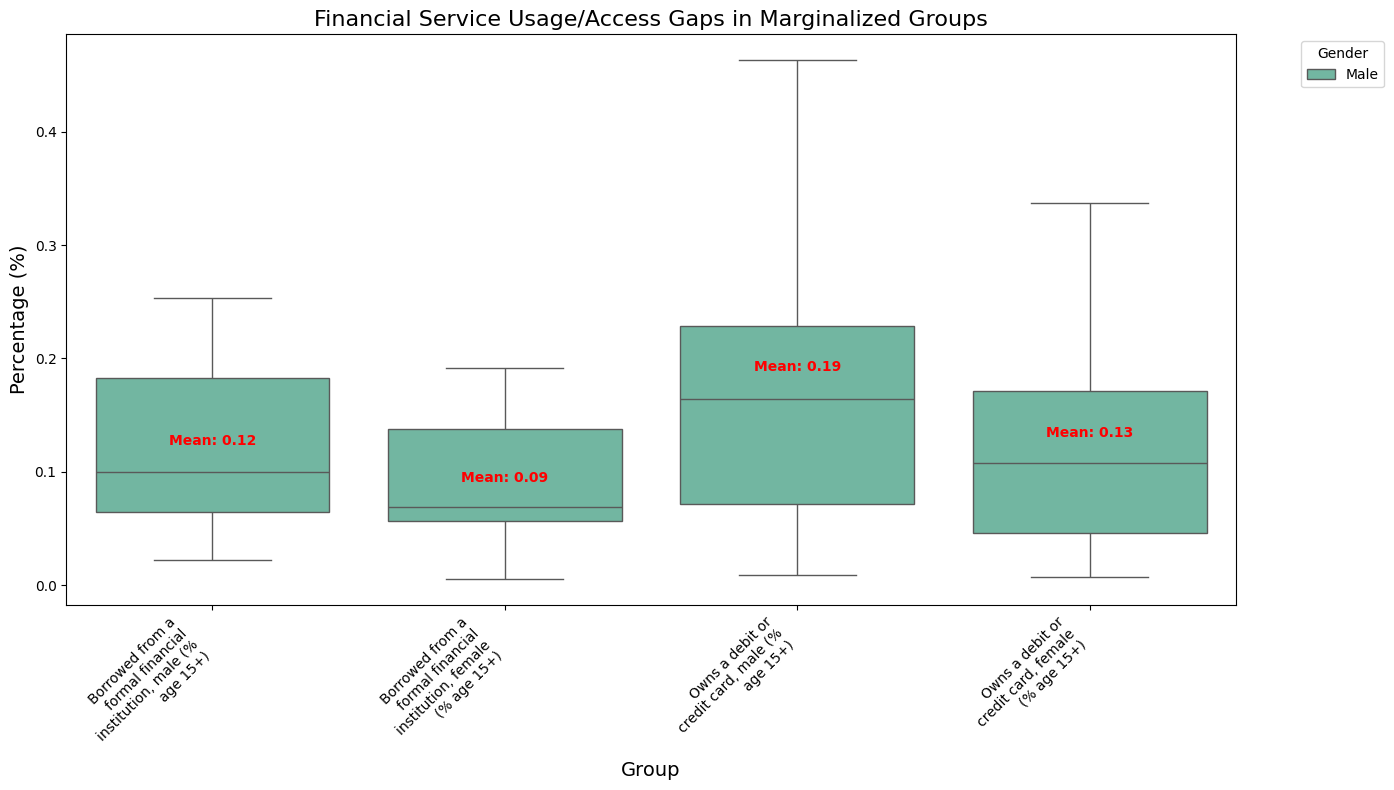

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import numpy as np
from scipy import stats

# Reshape the data for comparison
marginalized_groups = [
    'Borrowed from a formal financial institution, male (% age 15+)',
    'Borrowed from a formal financial institution, female (% age 15+)',
    'Owns a debit or credit card, male (% age 15+)',
    'Owns a debit or credit card, female (% age 15+)'
]

# Create a long-form DataFrame for Seaborn
comparison_data = ML_data[marginalized_groups].melt(var_name='Group', value_name='Percentage')

# Add a column to distinguish between male and female
comparison_data['Gender'] = comparison_data['Group'].apply(lambda x: 'Male' if 'male' in x else 'Female')

# Plot comparisons
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='Group', y='Percentage', hue='Gender', data=comparison_data, palette='Set2')

# Add mean and mode to the plot
for i, group in enumerate(marginalized_groups):
    # Filter data for the current group
    group_data = comparison_data[comparison_data['Group'] == group]['Percentage']
    
    # Calculate mean
    mean = group_data.mean()
    
    # Calculate mode (handle cases where mode might not exist)
    try:
        mode = stats.mode(group_data).mode[0]  # Calculate mode
    except IndexError:
        mode = np.nan  # If mode doesn't exist, set it to NaN
    
    # Add mean and mode to the plot (only if mode is not NaN)
    ax.text(i, mean, f'Mean: {mean:.2f}', color='red', ha='center', va='bottom', fontsize=10, fontweight='bold')
    if not np.isnan(mode):
        ax.text(i, mode, f'Mode: {mode:.2f}', color='blue', ha='center', va='top', fontsize=10, fontweight='bold')

# Wrap labels on the x-axis
wrapped_labels = [textwrap.fill(label, 20) for label in marginalized_groups]  # Wrap to 20 characters per line
plt.xticks(ticks=range(len(marginalized_groups)), labels=wrapped_labels, rotation=45, ha='right')

# Add title and labels
plt.title('Financial Service Usage/Access Gaps in Marginalized Groups', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Step 4: Build and Evaluate Predictive Models

In [ ]:


# Split into features (X) and target (y)
X = ML_data.drop(columns=['financial_inclusion_index'])  # Drop intermediate grades to avoid data leakage
y = ML_data['financial_inclusion_index']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from tabulate import tabulate

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Return results as a dictionary
    return {
        'Model': model.__class__.__name__,
        'MAE': round(mae, 2),
        'MSE': round(mse, 2),
        'R²': round(r2, 2)
    }

In [82]:
# Initialize models
models = [
    LinearRegression(),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    SVR(),
    KNeighborsRegressor()
]

# Evaluate each model
results = []
for model in models:
    results.append(evaluate_model(model, X_train, X_test, y_train, y_test))

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print results in a tabular format
print("Model Performance Comparison:")
print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

Model Performance Comparison:
+---------------------------+-------+--------+------+
|           Model           |  MAE  |  MSE   |  R²  |
+---------------------------+-------+--------+------+
|     LinearRegression      | 3.58  | 17.72  | 0.95 |
|   RandomForestRegressor   |  6.9  | 74.73  | 0.79 |
| GradientBoostingRegressor | 6.39  |  49.5  | 0.86 |
|            SVR            | 16.41 | 321.71 | 0.09 |
|    KNeighborsRegressor    | 10.32 | 126.3  | 0.64 |
+---------------------------+-------+--------+------+


Validate the Linear Regression Model
To validate the model, we'll use cross-validation to ensure its performance is consistent across different subsets of the data.

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Initialize the Linear Regression model
model = LinearRegression()

# Perform cross-validation (e.g., 5-fold)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')  # Use 'neg_mean_squared_error' for MSE

# Print cross-validation results
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", cv_scores.mean())

Cross-Validation R² Scores: [0.96858989 0.91270675 0.93018109 0.71194121 0.70611044]
Mean R² Score: 0.8459058738565716


Interpret the Model Coefficients
Linear Regression provides interpretable coefficients that indicate the relationship between each feature and the target variable.

In [84]:
# Train the model on the full training set
model.fit(X_train, y_train)

# Get the coefficients and corresponding feature names
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

# Sort by absolute value of coefficients to see the most important features
coefficients['Absolute_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Absolute_Coefficient', ascending=False)

# Print the coefficients
print("Model Coefficients:")
print(tabulate(coefficients, headers='keys', tablefmt='pretty', showindex=False))

Model Coefficients:
+-------------------------------------------------------------------------------+---------------------+----------------------+
|                                    Feature                                    |     Coefficient     | Absolute_Coefficient |
+-------------------------------------------------------------------------------+---------------------+----------------------+
|        Borrowed from a formal financial institution, male (% age 15+)         |  87.76455409148505  |  87.76455409148505   |
|       Borrowed from a formal financial institution, female (% age 15+)        | -86.42528576702784  |  86.42528576702784   |
|                       Has an active Account (% age 15+)                       |  77.23622415314723  |  77.23622415314723   |
|                Owns a debit or credit card, female (% age 15+)                |  64.54114764351998  |  64.54114764351998   |
|                 Owns a debit or credit card, male (% age 15+)                 | -42.31000

Make Predictions

In [85]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Compare predictions with actual values
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Print the first few predictions
print("Predictions vs Actual Values:")
print(tabulate(results.head(10), headers='keys', tablefmt='pretty', showindex=False))

Predictions vs Actual Values:
+--------------------+--------------------+
|       Actual       |     Predicted      |
+--------------------+--------------------+
| 11.45575315403667  | 18.461600399254735 |
| 11.524160331961783 | 14.55696263346316  |
| 54.302464194595814 | 55.15506504270332  |
| 41.47043835744264  | 38.022196688220376 |
+--------------------+--------------------+


Step 5: Evaluate the Model on the Test Set

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Model Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

Model Evaluation Metrics:
MAE: 3.58
MSE: 17.72
R²: 0.95
